# Analysis: Illusory Pitch

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Set file paths
E2_DATAFILE = '../data/scores.csv'
FIGURE_PATH = './figures/'

# Set colors
color1 = '#512D6D'
color2 = '#F8485E'

# Set line widths
lw = 1.5
capsize = 3
msize = 7

# Set fonts
small = 12
medium = 16
large = 20
plt.rc('font', size=small)          # controls default text sizes
plt.rc('axes', titlesize=large)     # fontsize of the axes title
plt.rc('axes', labelsize=medium)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small)    # fontsize of the tick labels
plt.rc('legend', fontsize=small)    # legend fontsize
plt.rc('figure', titlesize=large)  # fontsize of the figure title
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

### Load and preprocess data

In [2]:
# Load scores
data2 = pd.read_csv(E2_DATAFILE)

# Loftus & Masson (1994) method of plotting within-subject effects
subj_means = data2.groupby(['subject']).mean().reset_index()
grand_mean = subj_means.mean()
e2_within = data2.copy()
for i, subj in enumerate(subj_means.subject):
    e2_within.loc[e2_within.subject == subj, 'dprime'] -= subj_means.dprime[i] - grand_mean.dprime
    e2_within.loc[e2_within.subject == subj, 'C'] -= subj_means.C[i] - grand_mean.C

### Plot bias and sensitivity

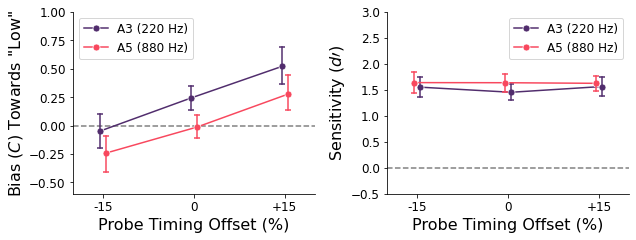

In [3]:
###
# Bias
###

plt.subplot(121)

# Plot average C per condition
plt.axhline(0, ls='--', c='k', alpha=.5)
sns.lineplot(x=e2_within.offset[e2_within.octave == 3]-.5, y='C', data=e2_within[e2_within.octave == 3],
             ls='-', lw=lw, marker='o', ms=msize, color=color1, label='A3 (220 Hz)',
             err_style='bars', err_kws=dict(capsize=capsize, lw=lw, capthick=lw))
sns.lineplot(x=e2_within.offset[e2_within.octave == 5]+.5, y='C', data=e2_within[e2_within.octave == 5],
             ls='-', lw=lw, marker='o', ms=msize, color=color2, label='A5 (880 Hz)',
             err_style='bars', err_kws=dict(capsize=capsize, lw=lw, capthick=lw))

# Stylize subplot
plt.xlim(-20, 20)
plt.xticks([-15, 0, 15], ['-15', '0', '+15'])
plt.ylim(-.6, 1)
plt.xlabel('Probe Timing Offset (%)')
plt.ylabel('Bias ($C$) Towards "Low"')


###
# Sensitivity
###

plt.subplot(122)

# Plot average d' per condition
plt.axhline(0, ls='--', c='k', alpha=.5)
sns.lineplot(x=e2_within.offset[e2_within.octave == 3]+.5, y='dprime', data=e2_within[e2_within.octave == 3],
             ls='-', lw=lw, marker='o', ms=msize, color=color1, label='A3 (220 Hz)',
             err_style='bars', err_kws=dict(capsize=capsize, lw=lw, capthick=lw))
sns.lineplot(x=e2_within.offset[e2_within.octave == 5]-.5, y='dprime', data=e2_within[e2_within.octave == 5],
             ls='-', lw=lw, marker='o', ms=msize, color=color2, label='A5 (880 Hz)',
             err_style='bars', err_kws=dict(capsize=capsize, lw=lw, capthick=lw))

# Sylize subplot
plt.xlim(-20, 20)
plt.xticks([-15, 0, 15], ['-15', '0', '+15'])
plt.ylim(-.5, 3)
plt.xlabel('Probe Timing Offset (%)')
plt.ylabel('Sensitivity ($d\prime$)')

# Stylize figure and save
plt.gcf().set_size_inches(9, 3.5)
plt.tight_layout()
plt.gcf().savefig(FIGURE_PATH + 'sdt_offset_within.svg')